## DATA IMPORTING

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [42]:
df1 = pd.read_csv('train.csv').dropna() #Training Dataset
df2 = pd.read_csv('test.csv') #Testing dataset
codf = pd.read_csv('US_COVID_data_state_level.csv') #Covid data of cities
cidf = pd.read_csv('city_details.csv') #Cities data
wadf = pd.read_csv('warehouse_mapping.csv') #Warehouse data

In [ ]:
df1['date']=pd.to_datetime(df1.date)
df1.sort_values('date',inplace = True)
df1.index = np.arange(df1.shape[0])
codf['date']=pd.to_datetime(codf.date)
codf.sort_values('date',inplace = True)
codf.index = np.arange(codf.shape[0])

## Predicting Confirmed Cases

In [ ]:
corl = codf[codf.conf_cases.notna()] #Non-empty cells of confirmed cases

In [ ]:
a,b = list(corl.tot_cases),list(corl.conf_cases)

In [ ]:
from sklearn.ensemble import RandomForestRegressor 
algo=RandomForestRegressor()
ratio = []
for i in range(len(a)):
    if b[i]!=0:
        ratio.append((a[i]-b[i])/(b[i]))
    else:
        ratio.append(0)
a=np.array(a).reshape(-1,1)
algo.fit(a,ratio)

RandomForestRegressor()

In [47]:
for i in codf[codf.conf_cases.isna()].index:
    codf.iloc[i,3] = int(np.array(codf.iloc[i,2])/(1+algo.predict(np.array(codf.iloc[i,2].reshape(1,-1)))))

In [48]:
codf.sample(5)

,date,state,tot_cases,conf_cases
2668,2020-02-25,DC,0,0.0
3553,2020-03-12,ME,12845,11391.0
8434,2020-06-04,HI,428,320.0
19097,2020-12-05,TX,41048,39351.0
17438,2020-11-06,TX,81583,77951.0


## DATA CLEANING

In [49]:
cidf1 = cidf.drop(['country'],axis = 1) #dropping useless columns
cidf1 = cidf1.drop_duplicates()
cidf1.tail(),cidf1.shape

(            city  zip_code state  state_name
 554  WESTMINSTER     92683    CA  CALIFORNIA
 555      ONTARIO     91761    CA  CALIFORNIA
 556       TACOMA     98409    WA  WASHINGTON
 557      BOZEMAN     59718    MT     MONTANA
 558    CLACKAMAS     97015    OR      OREGON,
 (555, 4))

In [50]:
state = cidf1.state.unique()
num_cities = [cidf1[cidf1.state == st].zip_code.nunique() for st in state]
stct = pd.DataFrame({'state':state,'num_cities':num_cities})

In [51]:
value,counts = np.unique(cidf1.zip_code,return_counts=True)
value[counts>1],counts[counts>1]

(array([94080, 98027], dtype=int64), array([2, 2], dtype=int64))

In [52]:
cidf1[cidf1.zip_code == 94080]

,city,zip_code,state,state_name
370,S,94080,CA,CALIFORNIA
371,EL,94080,CA,CALIFORNIA


In [53]:
cidf1.drop(index=371,inplace=True)

In [54]:
cidf1[cidf1.zip_code == 98027]

,city,zip_code,state,state_name
69,ISSAQUAH,98027,WA,WASHINGTON
70,US,98027,WA,WASHINGTON


In [55]:
cidf1.drop(index=70,inplace=True)

## DATA PREPROCESSING

In [56]:
cidf_final = cidf1.merge(stct,on = 'state',how = 'left')

In [57]:
wadf.sample(5)

,wh_id,warehouse_name
232,149,WAREHOUSE 149 SANTA CRUZ
44,1058,WAREHOUSE 1058 PARADISE VALLEY
18,1014,WAREHOUSE 1014 E COLORADO SPRINGS
506,737,WAREHOUSE 737 CENTENNIAL
537,780,WAREHOUSE 780 ENFIELD


In [58]:
m = codf.merge(cidf_final,how = 'left',on='state') 
print(m.shape)
m['avg_tot_cases'] = m['tot_cases']/m['num_cities']
m['avg_conf_cases'] = m['conf_cases']/m['num_cities']
m.sample(5) #merging covid data and cities data using state as a common entity

(276208, 8)


,date,state,tot_cases,conf_cases,city,zip_code,state_name,num_cities,avg_tot_cases,avg_conf_cases
273400,2021-12-01,WA,278544,221493.0,MARYSVILLE,98271.0,WASHINGTON,32.0,8704.500000,6921.656250
125003,2020-08-25,CA,717014,639303.0,SE,92102.0,CALIFORNIA,126.0,5690.587302,5073.833333
96034,2020-07-04,OR,1181,988.0,ROSEBURG,97470.0,OREGON,13.0,90.846154,76.000000
218085,2021-02-24,KY,400307,307541.0,NE,40241.0,KENTUCKY,4.0,100076.750000,76885.250000
152518,2020-10-15,CA,889394,773166.0,SAN,95112.0,CALIFORNIA,126.0,7058.682540,6136.238095


In [59]:
b = []
for row in wadf.values:
  b.append(row[1].split()[2]) #taking 3rd word from warehouse_name which is city

wadf['city'] = np.array(b)
wadf.sample(5)

,wh_id,warehouse_name,city
189,1318,WAREHOUSE 1318 MONTEREY PARK,MONTEREY
42,1049,WAREHOUSE 1049 ROCKWALL,ROCKWALL
5,1002,WAREHOUSE 1002 ANTIOCH,ANTIOCH
334,365,WAREHOUSE 365 CAGUAS,CAGUAS
19,1015,WAREHOUSE 1015 SAN DIMAS,SAN


In [60]:
x = df1.merge(wadf.drop(axis = 1,columns=['warehouse_name']),how='left',on = 'wh_id')

In [61]:
print(x.shape)
x.sample(5)
# merged data of train and warehouse datasets

(449995, 4)


,date,wh_id,sales,city
282061,2020-05-20,1101.0,407,PEWAUKEE
78404,2019-05-22,407.0,44,TUCSON
101327,2019-07-02,1275.0,16,SANTA
30437,2019-02-25,103.0,20,CLARKSTON
27422,2019-02-20,1039.0,24,BRANDYWINE


In [62]:
z = x.merge(m,how='left', on = ['date','city'])

In [63]:
print(z.shape)
z.sample(5)

(646135, 12)


,date,wh_id,sales,city,state,tot_cases,conf_cases,zip_code,state_name,num_cities,avg_tot_cases,avg_conf_cases
549176,2020-12-12,1364.0,60,BRADENTON,FL,1098341.0,1015312.0,34212.0,FLORIDA,28.0,39226.464286,36261.142857
472371,2020-09-27,1262.0,703,W,CO,69079.0,64237.0,80918.0,COLORADO,14.0,4934.214286,4588.357143
76252,2019-05-18,737.0,20,CENTENNIAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
554508,2020-12-17,322.0,269,BRIDGEWATER,NJ,461335.0,410677.0,8807.0,NEW JERSEY,20.0,23066.750000,20533.850000
594805,2021-02-03,778.0,354,FREMONT,CA,3520244.0,3520244.0,94538.0,CALIFORNIA,126.0,27938.444444,27938.444444


In [64]:
#precovid data
precov = z[z.state.isna()][['date','wh_id','sales','tot_cases','conf_cases','avg_tot_cases','avg_conf_cases']].fillna(0)
cov = z[z.state.notna()][['date','wh_id','sales','tot_cases','conf_cases','avg_tot_cases','avg_conf_cases']]

## EDA

In [131]:
# Import libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Configuring styles
sns.set_style("darkgrid")
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (25, 10)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [132]:
def week_avg_wh_id(wh_id):
    week_avg = []
    start = 0
    shape = df1[df1.wh_id == wh_id].shape[0]
    while start<shape:
        week_avg.append(df1[df1.wh_id == wh_id][start:start+7].sales.mean())
        start += 7
    return week_avg

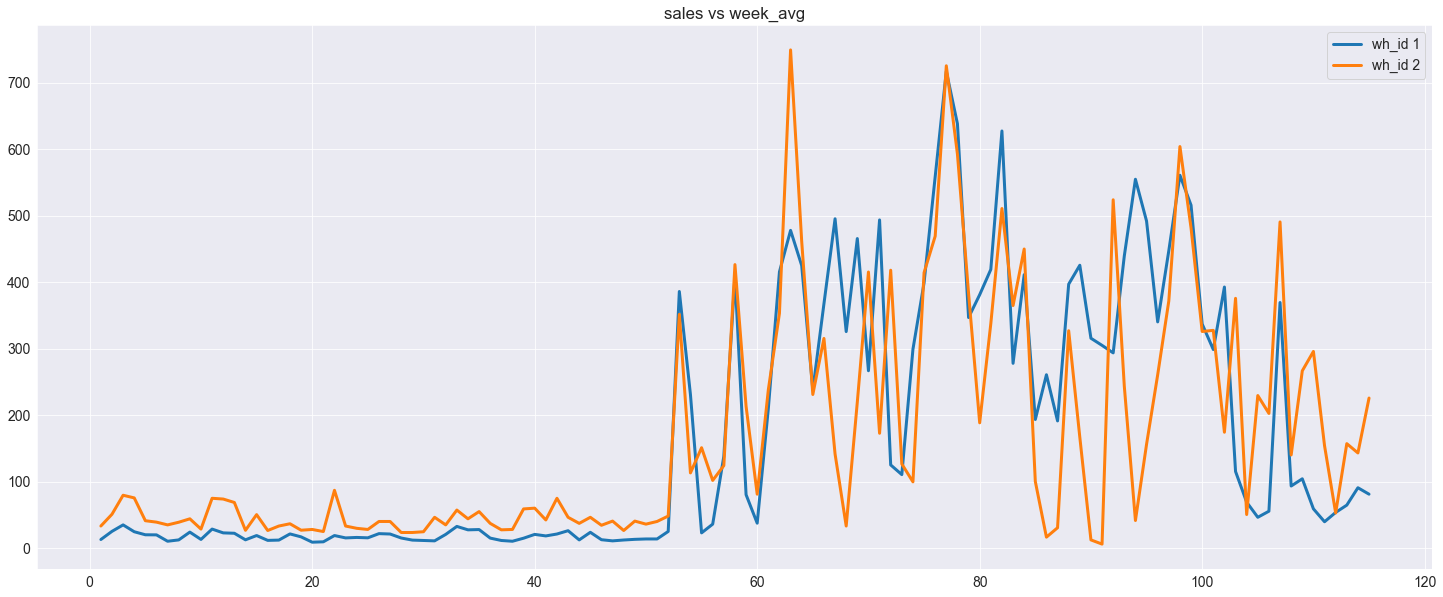

In [134]:
legend = []
for i in range(1,3):
    y = week_avg_wh_id(df1.wh_id.unique()[i])
    plt.plot(range(1,len(y)+1),y,linewidth = 3)
    legend.append('wh_id ' + str(i))
plt.legend(legend);
plt.title('sales vs week_avg');

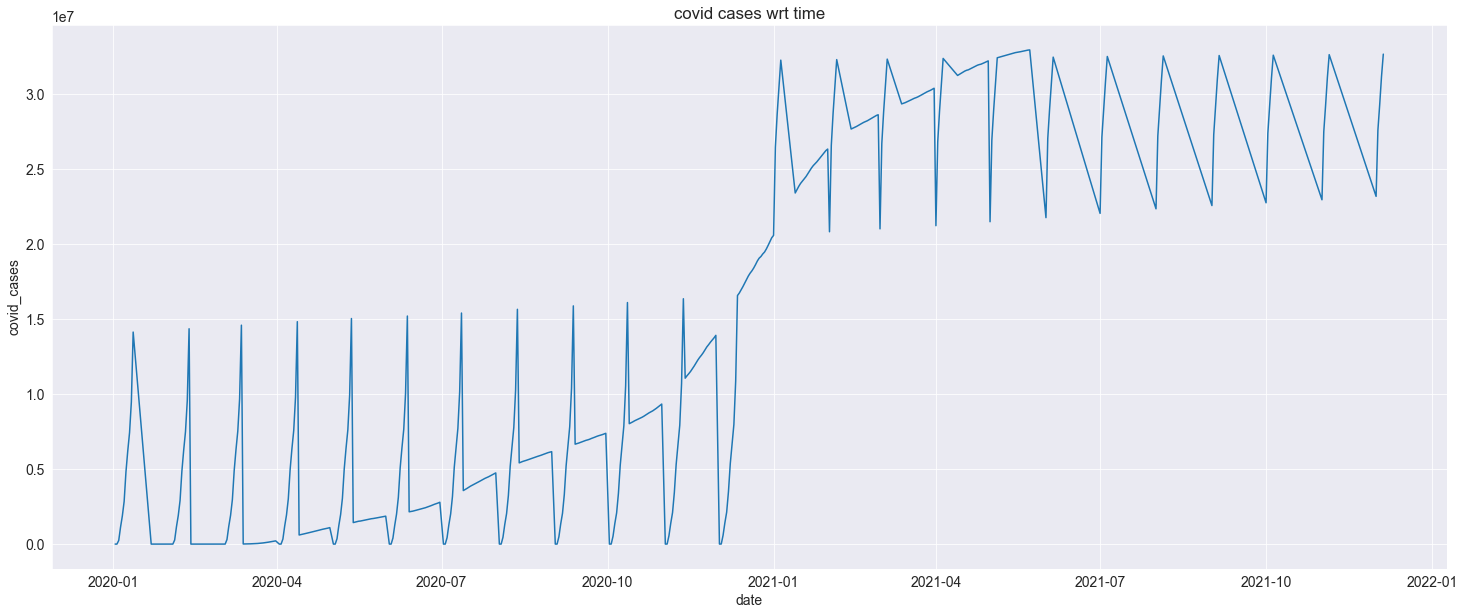

In [135]:
plt.plot(codf.date.unique(),codf.groupby('date').sum().tot_cases)
plt.title('covid cases wrt time')
plt.xlabel('date')
plt.ylabel('covid_cases');

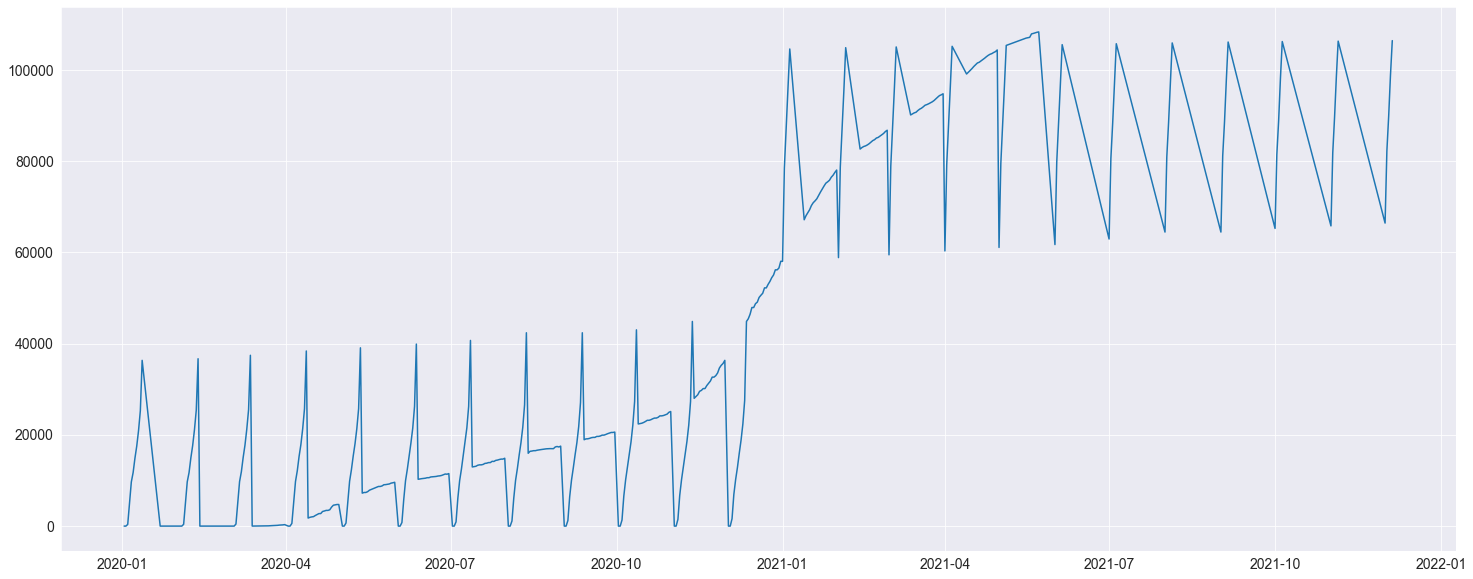

In [136]:
def cov_cases_state(state):
    plt.plot(codf[codf.state==state].date,codf[codf.state==state].tot_cases)
    
cov_cases_state('DE')

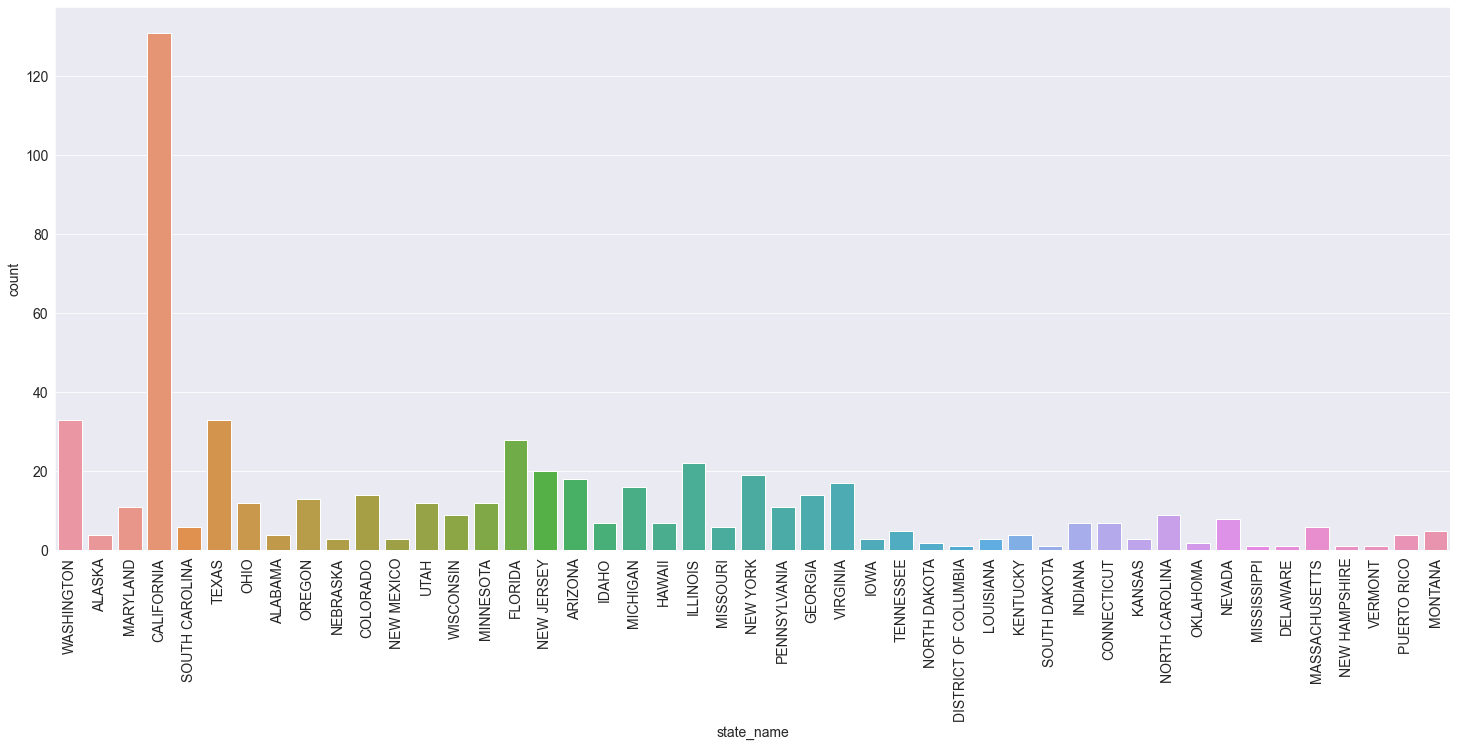

In [137]:
# State vs No.of cities
fig=sns.countplot(x=cidf.state_name);
plt.xticks(rotation=90);
plt.show();

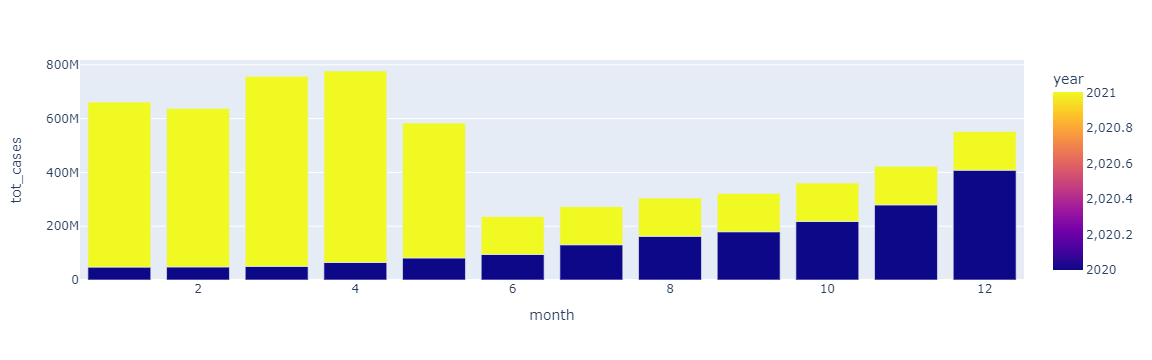

In [141]:
cov_eda_2020 = codf[codf.date.dt.year == 2020].groupby('month').sum()
cov_eda_2020['year'],cov_eda_2020['month'] = 2020,cov_eda_2020.index
cov_eda_2021 = codf[codf.date.dt.year == 2021].groupby('month').sum()
cov_eda_2021['year'],cov_eda_2021['month'] =2021,cov_eda_2021.index
cov_eda = pd.concat([cov_eda_2020,cov_eda_2021])
px.bar(cov_eda,x='month',y='tot_cases',color = 'year')